In [ ]:
import os
import time
import io
import base64

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    fbeta_score
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.ensemble import IsolationForest


In [ ]:
#df of jpeg_bytes and their labels
df = pd.read_pickle('/kaggle/input/df-original/df.pkl')
df.head()

,image_id,image_bytes,target
0,ISIC_0015670,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
1,ISIC_0015845,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
2,ISIC_0015864,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
3,ISIC_0015902,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0
4,ISIC_0024200,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,0


In [ ]:
class_1_df = df[df['target'] == 1]
class_0_df = df[df['target'] == 0]


In [ ]:
class_1_df_train, class_1_df_val = train_test_split(
    class_1_df, test_size=0.2, random_state=42
)

In [ ]:
#Augmentation

image_size = 224 # same as the models werw trained on before



augmentation_transforms = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),

    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.0,
        p=0.75
    ),

    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        #A.GaussNoise(var_limit=(1.0, 1.0)),
    ], p=0.7),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),

    A.CLAHE(clip_limit=4.0, p=0.7),

    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),


    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),

    A.Resize(image_size, image_size),

    A.CoarseDropout(
        max_holes=1,
        max_height=int(image_size * 0.375),
        max_width=int(image_size * 0.375),
        fill_value=0,
        p=0.7
    ),
])


transforms_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

# Function to augment JPEG bytes and return JPEG bytes
def augment_image_bytes(img_bytes):
    img = Image.open(BytesIO(img_bytes)).convert('RGB')
    img_np = np.array(img)
    aug_img_np = augmentation_transforms(image=img_np)["image"]

    if aug_img_np.dtype != np.uint8:
        aug_img_np = np.clip(aug_img_np, 0, 255).astype(np.uint8)

    # Convert back to JPEG bytes
    aug_img_pil = Image.fromarray(aug_img_np, mode='RGB')
    buffer = BytesIO()
    aug_img_pil.save(buffer, format="JPEG")
    return buffer.getvalue()

# Apply augmentation to the dataframe
class_1_df_augmented = pd.DataFrame()
class_1_df_augmented['image_bytes'] = class_1_df_train['image_bytes'].apply(augment_image_bytes)

# Keep label if exists
if 'label' in class_1_df.columns:
    class_1_df_augmented['label'] = class_1_df['label']

class_1_df_augmented['target'] = 1
print(class_1_df_augmented.head())

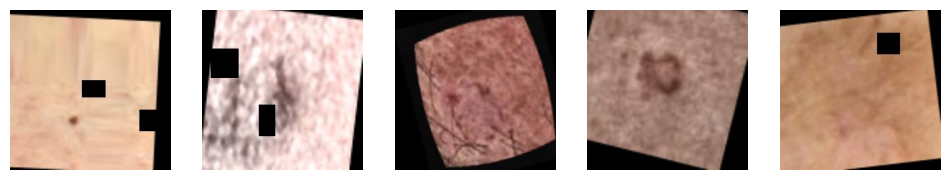

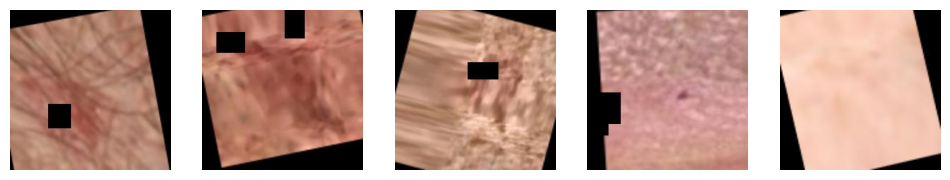

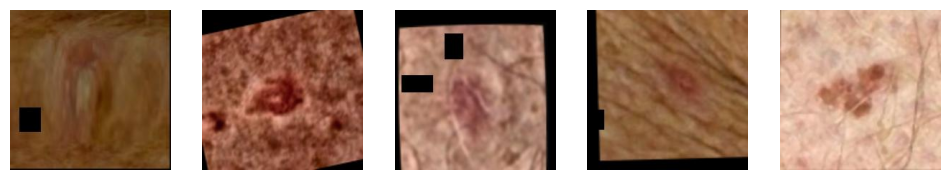

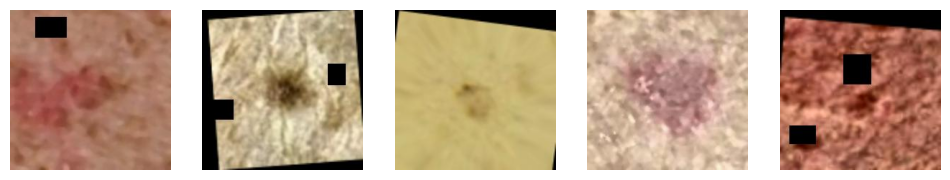

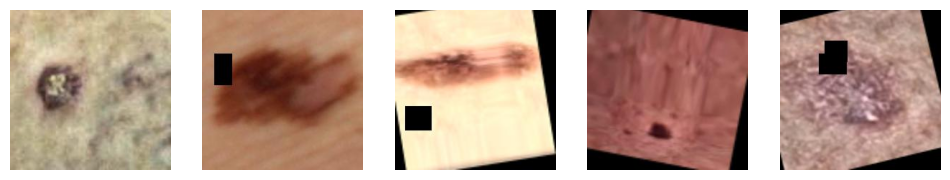

In [50]:
#Prints some random Augmented Images
for i in range(5):
    n = 5
    sample_df = class_1_df_augmented.sample(n)
    
    plt.figure(figsize=(12, 4))
    for i, img_bytes in enumerate(sample_df['image_bytes']):
        img = Image.open(BytesIO(img_bytes))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

In [ ]:
class_1_df_train = pd.concat([class_1_df_train, class_1_df_augmented], ignore_index=True)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [53]:
image_size = 224

data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),  # simple augmentations
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    ),
])


In [ ]:
class_0_df_train, class_0_df_val = train_test_split(
    class_0_df, test_size=0.2, random_state=42
)



df_train = pd.concat([class_0_df_train, class_1_df_train], ignore_index=True)
df_val = pd.concat([class_0_df_val, class_1_df_val], ignore_index=True)

In [54]:
class JpegBytesDataset(Dataset):
    def __init__(self, df, image_col='image_bytes', label_col='target', transform=None):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        jpeg_bytes = self.df.iloc[idx][self.image_col]

        # Decode base64 if it's a string
        if isinstance(jpeg_bytes, str):
            image_data = base64.b64decode(jpeg_bytes)
        else:
            image_data = jpeg_bytes

        image = Image.open(io.BytesIO(image_data)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.df.iloc[idx][self.label_col]
        return image, label




train_dataset = JpegBytesDataset(df_train, transform=data_transforms)
val_dataset = JpegBytesDataset(df_val, transform=data_transforms)
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [56]:
#To gradually increase negative data in training

def reset_loaders(num, class_0_df_train = class_0_df_train, class_0_df_val = class_0_df_val, class_1_df_train = class_1_df_train, class_1_df_val = class_1_df_val):

    class_0_train_sampled = class_0_df_train.sample(n=num)
    class_0_val_sampled = class_0_df_val.sample(n=int(num/5))

    df_train = pd.concat([class_0_train_sampled, class_1_df_train], ignore_index=True)
    df_val = pd.concat([class_0_val_sampled, class_1_df_val], ignore_index=True)
    
    train_dataset = JpegBytesDataset(df_train, transform=data_transforms)
    val_dataset = JpegBytesDataset(df_val, transform=data_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader

In [ ]:

# To change weight of cost function dynamically
def get_class_weights(n_class0, n_class1, device="cuda"):
    """
    Calculate inverse-frequency class weights for binary classification.

    Args:
        n_class0 (int): Number of samples in class 0.
        n_class1 (int): Number of samples in class 1.
        device (str): Device to place the weights tensor on.

    Returns:
        torch.Tensor: Weights for [class0, class1].
    """
    total = n_class0 + n_class1
    weight0 = total / (2.0 * n_class0)
    weight1 = total / (2.0 * n_class1)
    
    weights = torch.tensor([weight0, weight1], dtype=torch.float32).to(device)
    return weights


class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(
            inputs, targets, weight=self.alpha, reduction="none"
        )
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
def train_and_validate(
    model,
    train_loader,
    val_loader,
    device='cuda',
    n_epochs=15,
    init_lr=3e-5,
    gamma=2.0,           # focal loss gamma
    alpha=None,          # focal loss alpha (class weights)
    grad_clip=None,
    kernel_type="model",
    out_dim=2,
    log_dir="./logs",
    model_dir="./weights",
    no_neg_init=5,
    no_pos=800
):
    l = 0
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # Device
    device = torch.device(device)
    model = model.to(device)

    # Initial weights & loss
    no_neg = no_neg_init
    if alpha is not None:
        alpha = torch.tensor(alpha, device=device)
    weights = get_class_weights(no_neg, no_pos, device=device)
    criterion = nn.CrossEntropyLoss(weight=weights)


    from torch.optim import AdamW

    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        # Skip frozen layers
        if not param.requires_grad:
            continue
    
        # No decay for biases and normalization parameters
        if param.ndimension() == 1 or name.endswith(".bias"):
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    optimizer = AdamW(
        [
            {'params': decay_params, 'weight_decay': 1e-4},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ],
        lr=init_lr
    )

    best_auc = 0.0

    for epoch in range(n_epochs):
        # Reset dataset & update alpha every n epochs
        train_loader, val_loader = reset_loaders(no_neg)
        if epoch % 3 == 0:
            print(f"Epoch {epoch}: Resetting loader with {no_neg} negatives")
            train_loader, val_loader = reset_loaders(no_neg)
            print(f"Train samples: {len(train_loader.dataset)}")

            weights = get_class_weights(no_neg, no_pos, device=device)
            criterion = nn.CrossEntropyLoss(weight=weights)
            no_neg += 1000

        print(f"{time.ctime()} Epoch {epoch}/{n_epochs}")

        # TRAIN
        model.train()
        train_losses = []
        for inputs, targets in tqdm(train_loader, desc="Train"):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # VALIDATE
        print(f"Val samples: {len(val_loader.dataset)}")
        model.eval()
        val_losses = []
        all_preds, all_targets = [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Val"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_losses.append(loss.item())

                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                all_preds.append(probs)
                all_targets.append(targets.cpu().numpy())

        # Metrics
        val_loss = np.mean(val_losses)
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)

        auc = roc_auc_score(all_targets, all_preds)

        threshold = 0.2
        pred_labels = (all_preds >= threshold).astype(int)

        acc = accuracy_score(all_targets, pred_labels)
        precision = precision_score(all_targets, pred_labels, zero_division=0)
        recall = recall_score(all_targets, pred_labels, zero_division=0)

        pred_labels = (all_preds >= threshold).astype(int)
        
        f1 = fbeta_score(all_targets, pred_labels, beta=1)  # regular F1
        f2 = fbeta_score(all_targets, pred_labels, beta=2)  # F2 score

        balanced_acc = balanced_accuracy_score(all_targets, pred_labels)

        cm = confusion_matrix(all_targets, pred_labels, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        if 1.3 * avg_train_loss < avg_train_loss:
            l += 1
        if l == 2:
            break

        print(
            f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | AUC: {auc:.4f} |"
            f"Best AUC: {best_auc:.4f}"
        )
        print(
            f"Acc: {acc:.4f} | Bal Acc: {balanced_acc:.4f} | "
            f"Precision: {precision:.4f} | Recall: {recall:.4f} | "
            f"F1: {f1:.4f} | F2: {f2:.4f} | Specificity: {specificity:.4f} | "
            f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}"
        )
        prec, rec, thresh = precision_recall_curve(all_targets, all_preds)
        f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)  # avoid div by zero
        best_thresh = thresh[np.argmax(f1_scores)]
        print(f"Best threshold for F1 this epoch: {best_thresh:.4f}")
        
        # Optional: recalc metrics with this threshold
        pred_labels = (all_preds >= best_thresh).astype(int)

        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), os.path.join(model_dir, f"{kernel_type}_best.pth"))


In [ ]:
# Load pretrained EVA02 model
model = timm.create_model("eva02_base_patch14_224.mim_in22k", pretrained=True)

# Freeze all parameters initially
for param in model.parameters():
    param.requires_grad = False

# Replace the 'head' (classifier) with new output layer for 2 classes
in_features = model.num_features
model.head = nn.Linear(in_features, 2)

# Unfreeze classifier head
for param in model.head.parameters():
    param.requires_grad = True

# Unfreeze the second last transformer block
if hasattr(model, "blocks") and len(model.blocks) >= 2:
    second_last_block = model.blocks[-2]
    for param in second_last_block.parameters():
        param.requires_grad = True
else:
    print("Model does not have a 'blocks' attribute or has fewer than 2 blocks.")

# List trainable parameters
trainable_params = [name for name, p in model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable_params)

In [ ]:
train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device="cuda",
    n_epochs=10,
    init_lr=5e-5,             
    grad_clip=1.0,
    kernel_type="my_experiment",
    out_dim=2,             
    log_dir="./logs",
    model_dir="./weights",
    no_neg_init=5000
)

In [ ]:
#save weights
torch.save(model.state_dict(), "eva02_earlystop.pth")

The code after this is loading models for some matrics calculation

In [ ]:



class MyEdgeNeXt(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        # Replace head with 2 classes
        self.base.head = nn.Linear(self.base.num_features, 2)

    def forward(self, x):
        x = self.base.forward_features(x)
        if x.ndim == 4:  # (B, C, H, W)
            x = x.mean(dim=[2, 3])
        elif x.ndim == 3:  # (B, N, C)
            x = x.mean(dim=1)
        x = self.base.head(x)
        return x


def build_and_load_model(weight_path):
    # Create base model
    base_model = timm.create_model("edgenext_xx_small", pretrained=False)

    # Freeze all parameters
    for param in base_model.parameters():
        param.requires_grad = False

    # Replace head
    in_features = base_model.num_features
    base_model.head = nn.Linear(in_features, 2)

    # Unfreeze head
    for param in base_model.head.parameters():
        param.requires_grad = True

    # Unfreeze last 2 stages
    if hasattr(base_model, "stages") and len(base_model.stages) >= 2:
        for stage in base_model.stages[-2:]:
            for param in stage.parameters():
                param.requires_grad = True

    # Wrap with custom forward
    model = MyEdgeNeXt(base_model)

    # Load saved weights
    state_dict = torch.load(weight_path, map_location="cpu")
    model.load_state_dict(state_dict)
    print("loaded model")

    return model

model = build_and_load_model("/kaggle/input/ok/tensorflow2/default/1/edgenext_xx_final.pth")
model = model.to(device)

loaded model


In [128]:
class_0_train_sampled = class_0_df.sample(n=10000)

df_val = pd.concat([class_0_train_sampled, class_1_df], ignore_index=True)

val_dataset = JpegBytesDataset(df_val, transform=data_transforms)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# Calculate outputs on the dataframe

alpha = None
gamma = 2.0
criterion = FocalLoss(alpha=alpha, gamma=gamma)

model.eval()
val_losses = []
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in tqdm(val_loader, desc="Val"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_losses.append(loss.item())

        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        all_preds.append(probs)
        all_targets.append(targets.cpu().numpy())

# Metrics
val_loss = np.mean(val_losses)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

Val: 100%|██████████| 325/325 [00:41<00:00,  7.82it/s]


In [ ]:
# Calculate metrics for the outputs

auc = roc_auc_score(all_targets, all_preds)

threshold = 0.2
pred_labels = (all_preds >= threshold).astype(int)

acc = accuracy_score(all_targets, pred_labels)
precision = precision_score(all_targets, pred_labels, zero_division=0)
recall = recall_score(all_targets, pred_labels, zero_division=0)

pred_labels = (all_preds >= threshold).astype(int)

f1 = fbeta_score(all_targets, pred_labels, beta=1)  # regular F1
f2 = fbeta_score(all_targets, pred_labels, beta=2)  # F2 score

balanced_acc = balanced_accuracy_score(all_targets, pred_labels)

cm = confusion_matrix(all_targets, pred_labels, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(
    f"Precision: {precision:.4f} | Recall: {recall:.4f} | "
    f"F1: {f1:.4f} | F2: {f2:.4f} | Specificity: {specificity:.4f} | "
    f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}"
)
prec, rec, thresh = precision_recall_curve(all_targets, all_preds)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)  # avoid div by zero
best_thresh = thresh[np.argmax(f1_scores)]
print(f"Best threshold for F1 this epoch: {best_thresh:.4f}")

Precision: 0.3012 | Recall: 0.8117 | F1: 0.4394 | F2: 0.6062 | Specificity: 0.9260 | TP: 319, FP: 740, FN: 74, TN: 9260
Best threshold for F1 this epoch: 0.7149


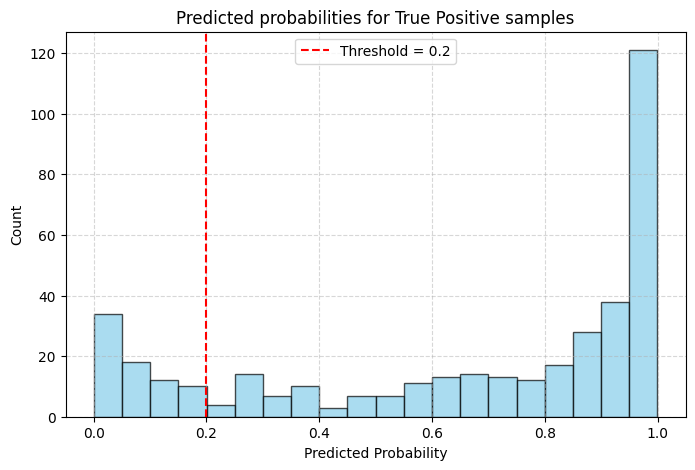

In [ ]:
#plotting predicted values for all +ve images

# Convert to NumPy arrays if they aren't already
all_targets = np.array(all_targets)
all_preds = np.array(all_preds)

# Filter only true positive samples (actual label = 1)
true_positive_mask = (all_targets == 1)
true_positive_preds = all_preds[true_positive_mask]

# Plot histogram of predictions for true positives
plt.figure(figsize=(8, 5))
plt.hist(true_positive_preds, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Predicted probabilities for True Positive samples")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


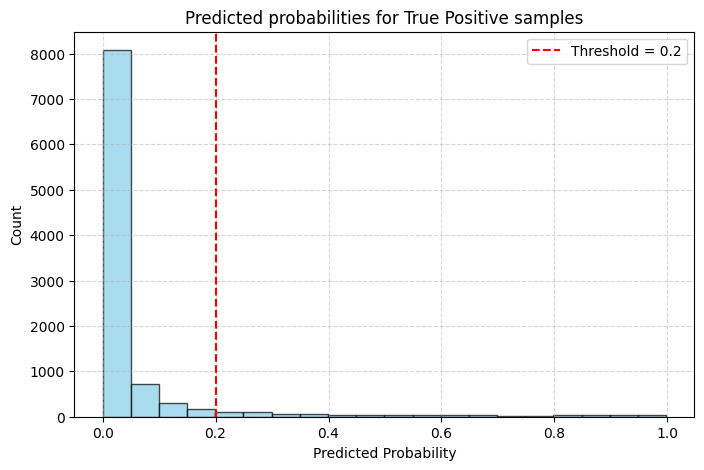

In [ ]:
#plotting predicted values for all -ve images

# Convert to NumPy arrays if they aren't already
all_targets = np.array(all_targets)
all_preds = np.array(all_preds)

# Filter only true positive samples (actual label = 1)
true_positive_mask = (all_targets == 0)
true_positive_preds = all_preds[true_positive_mask]

# Plot histogram of predictions for true positives
plt.figure(figsize=(8, 5))
plt.hist(true_positive_preds, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Predicted probabilities for True Positive samples")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Found 2 confidently wrong positives.


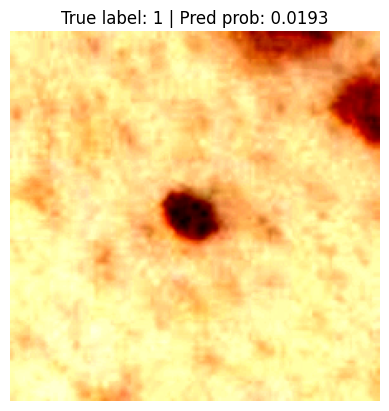

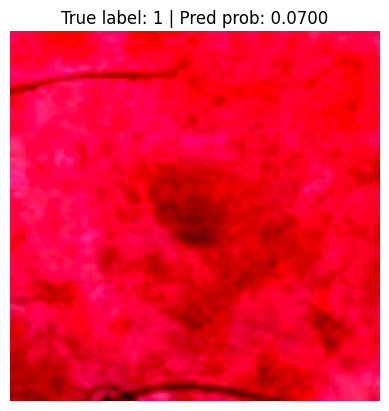

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to NumPy
all_targets = np.array(all_targets)
all_preds = np.array(all_preds)

# Set a "confident wrong" threshold for false negatives (pred << threshold)
conf_threshold = 0.1  # means model is very sure it's negative

# Find indices of confident wrong predictions (false negatives)
wrong_conf_mask = (all_targets == 1) & (all_preds < conf_threshold)
wrong_conf_indices = np.where(wrong_conf_mask)[0]

print(f"Found {len(wrong_conf_indices)} confidently wrong positives.")

# Plot or print them
for idx in wrong_conf_indices:
    plt.figure()
    plt.imshow(val_dataset[idx][0].permute(1, 2, 0))  # assuming dataset returns (image, label)
    plt.title(f"True label: 1 | Pred prob: {all_preds[idx]:.4f}")
    plt.axis("off")
    plt.show()
